In [4]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
import matplotlib 


from itertools import product

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

import h5py
from dustapprox.models import PrecomputedModel

import emcee

In [5]:
distance = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 200)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

(200, 200, 200)


shape: (601, 601, 161)
(601, 601, 161)


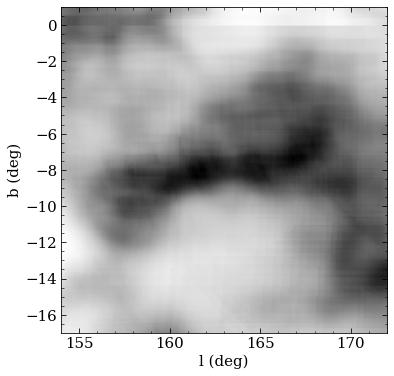

In [6]:
### Get Vergely+ (2022) dustmap for same points as Bayestar, now that it's in dustmaps
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')
vergely = vergelyquery(coords) * A0Coeff
verg_reddening = np.cumsum(vergely, axis = 2) * 5


fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
plt.show()

In [7]:
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/CACloudResiduals/'
respath  = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/'
CA_meta = Table(fits.open(CAresdir + 'CA_meta.fits')[1].data)

tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

stars_addon = stars['APOGEE_ID', 'SFD_EBV', 'SNR', 'ASPCAPFLAG', 'STARFLAG', 'ASPCAP_CHI2']
CA_meta['DIST'] = 1000 / CA_meta['GAIAEDR3_PARALLAX']

CA_meta = join(CA_meta, stars_addon, keys = 'APOGEE_ID', join_type = 'left',)

CA_meta = CA_meta[(CA_meta['DIST'] > 250) & (CA_meta['DIST'] < 800)]

starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [8]:
lambda0 = 15272.42 
sigma0 = 1.37

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [9]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

for i in range(100):
    asdf = get_ca_res(CA_meta[i]['FILE'])
    try:
        fits.open(asdf)
    except:
        print('file doesnt exist')
        

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [10]:
def find_nearest(ll, bb):
    l_sel = l[0, :, 0]
    b_sel = b[:, 0,0]

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[l_ind, b_ind, :])

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[l_ind, b_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline))
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

In [11]:
res_array = np.zeros((len(CA_meta), len(wavs_window)))
dustmaps_inds = np.zeros((len(CA_meta), 3)).astype(int)

for i in range(len(CA_meta)):
    star = CA_meta[i]
    try:
        res_hdu = fits.open(get_ca_res(star['FILE']))
        res_array[i, :] = res_hdu[1].data[window]
    except:
        res_array[i, :] = np.nan

    try:
        l_ind, b_ind = find_nearest(star['GLON'], star['GLAT'])
        d_ind = find_nearest_dist(star['DIST'])
        dustmaps_inds[i, :] = np.array((l_ind, b_ind, d_ind))
    except:
        dustmaps_inds[i, :] = 0


/tmp/ipykernel_2898660/1447256354.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dustmaps_inds[i, :] = np.array((l_ind, b_ind, d_ind))


In [12]:
CA_meta['Dustmap_AV'] = verg_reddening[dustmaps_inds[:, 0], dustmaps_inds[:, 1], dustmaps_inds[:, 2]]

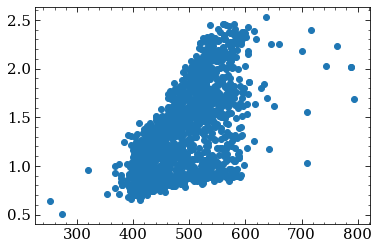

In [13]:
fig, ax = plt.subplots()
ax.scatter(CA_meta['DIST'], CA_meta['Dustmap_AV'])
plt.show()

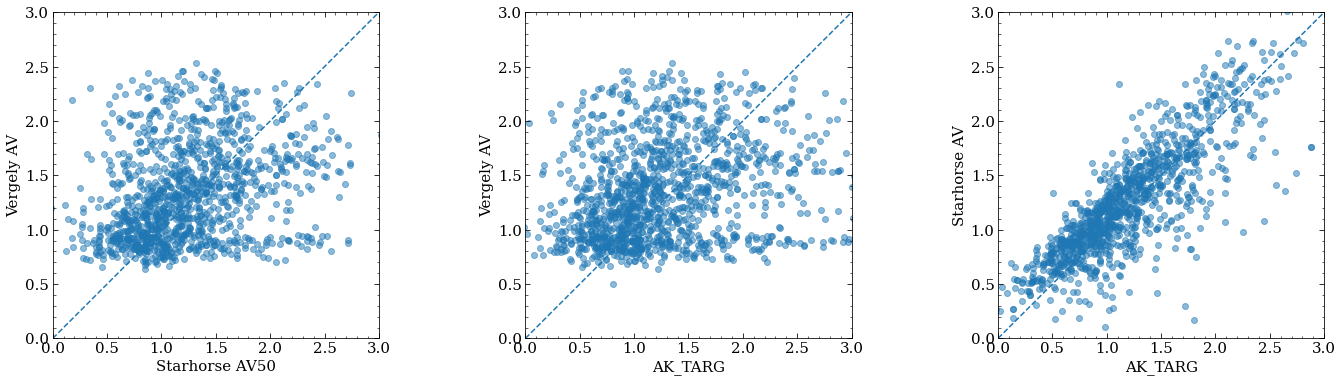

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 6))
axs[0].scatter(CA_meta['AV50'], CA_meta['Dustmap_AV'], alpha = 0.5)
axs[0].set_xlabel('Starhorse AV50')
axs[0].set_ylabel('Vergely AV')
axs[0].plot([0,3], [0,3], linestyle = 'dashed')
axs[0].set_aspect('equal')
axs[0].set_xlim(0, 3)
axs[0].set_ylim(0,3)

axs[1].scatter(CA_meta['AK_TARG'] / 0.302 * 2.742, CA_meta['Dustmap_AV'], alpha = 0.5)
axs[1].set_xlim(0, 3)
axs[1].set_ylim(0,3)
axs[1].set_xlabel('AK_TARG')
axs[1].set_ylabel('Vergely AV')
axs[1].plot([0,3], [0,3], linestyle = 'dashed')
axs[1].set_aspect('equal')

axs[2].scatter(CA_meta['AK_TARG'] / 0.302 * 2.742, CA_meta['AV50'], alpha = 0.5)
axs[2].set_xlim(0, 3)
axs[2].set_ylim(0,3)
axs[2].set_xlabel('AK_TARG')
axs[2].set_ylabel('Starhorse AV')
axs[2].plot([0,3], [0,3], linestyle = 'dashed')
axs[2].set_aspect('equal')
fig.set_facecolor('white')
plt.show()

In [15]:
# Make plot of DIB EQW (gaussian or integ) vs
# STARHORSE
# AK_TARG
# VERGELY
# BAYESTAR

In [17]:
output_tab = CA_meta['GLON', 'GLAT', 'DIST']
output_tab.write('../Data/Temporary/CA_meta_coords.csv')

In [67]:
def model(x, mu, sig, A, m, b ):
    return m * x + b - A * np.exp(-(x - mu)**2 / (2 * sig**2))

def line(x, m, b):
    return m * x + b

In [68]:
from scipy.optimize import curve_fit

In [69]:
# wavs_window_repeat = np.repeat(wavs_window, len(res_array)).reshape(len(res_array), -1)
fit_params = np.zeros((len(CA_meta), 5, 2))
for i in range(len(CA_meta)):
    try:
        fit_result = curve_fit(model, wavs_window, res_array[i, :], p0 = (lambda0, 1.5, 0.05, 0, 1), bounds = ((lambda0-4, 0.5, 0, -.05, .95), (lambda0+4,  3,   .15,  .05, 1.05)), check_finite  = False)
        fit_params[i, :, 0] = fit_result[0]
        fit_params[i, :, 1] = np.sqrt(np.diag(fit_result[1]))


    except:
        fit_params[i, : , 0] = np.nan
        fit_params[i, : , 1] = np.nan

In [70]:
AV = np.array(CA_meta['Dustmap_AV'])
amplitude = fit_params[:, 2, 0]
amplitude_errs = fit_params[:, 2, 1]
AV.shape == amplitude.shape

True

shape: (601, 601, 161)
(601, 601, 161)


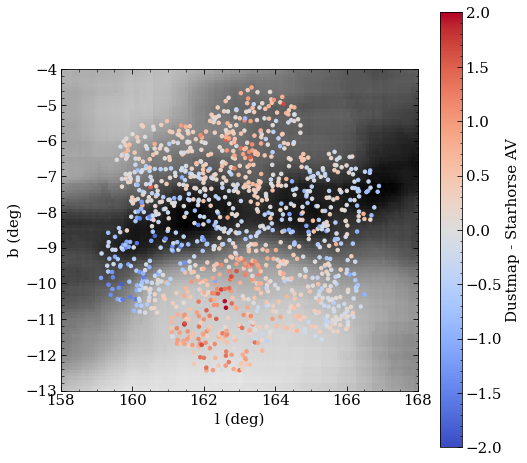

In [14]:
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')



fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.set_xlim(158, 168)
ax.set_ylim(-13, -4)

norm = matplotlib.colors.Normalize(-2, 2)
points = ax.scatter(CA_meta['GLON'], CA_meta['GLAT'], c= CA_meta['Dustmap_AV'] - CA_meta['AV50'], s = 12, cmap = 'coolwarm', norm = norm)
fig.colorbar(points, label = 'Dustmap - Starhorse AV', )
fig.set_facecolor('white')

plt.show()

shape: (601, 601, 161)
(601, 601, 161)


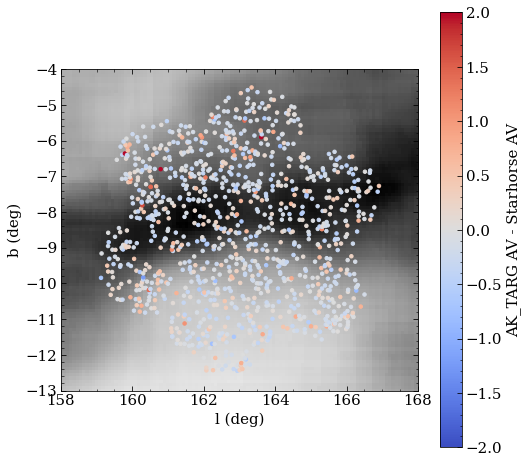

In [107]:
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')



fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.set_xlim(158, 168)
ax.set_ylim(-13, -4)

norm = matplotlib.colors.Normalize(-2, 2)
points = ax.scatter(CA_meta['GLON'], CA_meta['GLAT'], c= CA_meta['AK_TARG'] / 0.302 * 2.742 - CA_meta['AV50'], s = 12, cmap = 'coolwarm', norm = norm)
fig.colorbar(points, label = 'AK_TARG AV - Starhorse AV', )

plt.show()

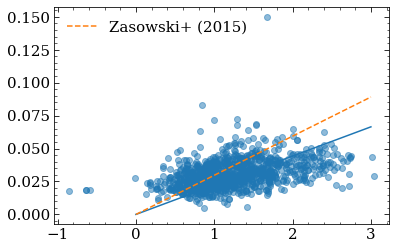

In [82]:
fig, ax= plt.subplots()
mguess = 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3

# line = lambda x, m, b : m * x + b
# line_param = curve_fit(line, AV, amplitude, p0 = [1/(np.sqrt(2 * np.pi) * 1.5) * 102e-3 * 0.5, 0.05], bounds = ((-0.1, -0.05), (.5, .05)), check_finite = False)
select_fit = (np.isnan(amplitude) == False) & (np.isnan(amplitude_errs) == False)
amplitude_fit = np.copy(amplitude)[select_fit]
amplitude_fit_errs = np.copy(amplitude_errs)[select_fit]

line_param = curve_fit(line, CA_meta['AV50'][select_fit], amplitude_fit, p0 = [mguess,0], bounds = ((0, -0.0001),(0.1, 0.000)), check_finite= False, sigma = amplitude_fit_errs)#bounds = ((-0.1, -0.05), (.5, .05))

ax.scatter(CA_meta['AV50'],  amplitude, alpha = 0.5)
# plot versus starhorse and AK_TARG

xx = np.linspace(0,3)
ax.plot(xx, line(xx, *line_param[0]))

ax.plot(xx, line(xx, mguess, 0), label = 'Zasowski+ (2015)', linestyle = 'dashed')
ax.legend()

# ax.set_xlim(0, 3)
plt.show()

In [83]:
print(line_param)
print(mguess)

(array([ 2.21529967e-02, -1.73865439e-20]), array([[ 4.82646764e-07, -5.59965054e-07],
       [-5.59965054e-07,  7.99056744e-07]]))
0.029702271971493527


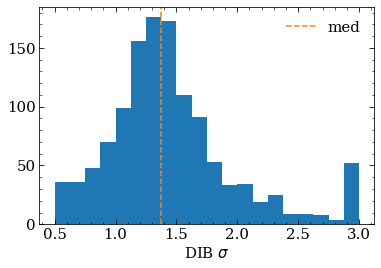

In [73]:
fig, ax = plt.subplots()
ax.hist(fit_params[:, 1, 0], bins = 20)

sig_med = np.nanmedian(fit_params[:, 1, 0])

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.plot([sig_med, sig_med], [ymin, ymax], linestyle = 'dashed', label = 'med')
ax.legend()
ax.set_xlabel('DIB $\sigma$')
plt.show()
